# IMPLEMENTATION OF BASIC RAG ON A PAPER

**WHAT IS RAG ( Retrieval Augmented Generation ) ?**
- RAG is the process of retrieving relevant contextual information from a data source and passing that information to a large language model        alongside the user’s prompt. This information is used to improve the model’s output by augmenting the model’s base knowledge. 

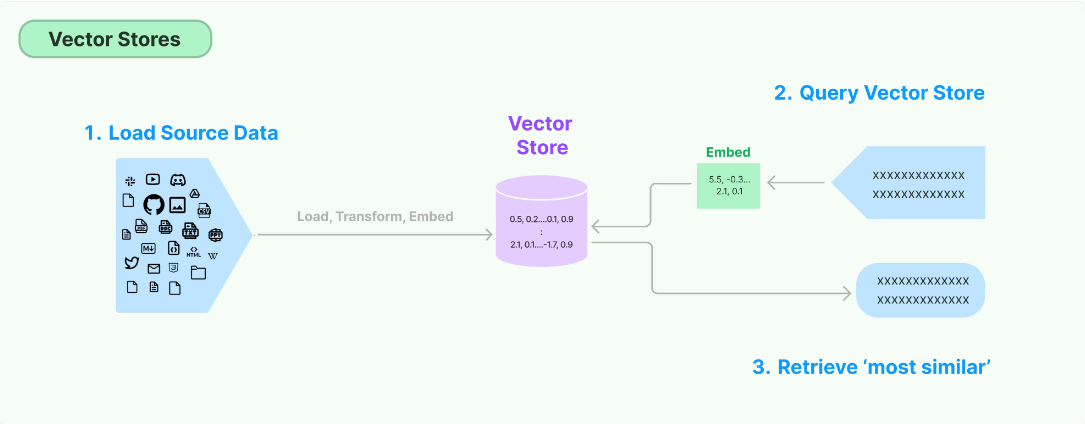

In [2]:
#import os and load_dotenv 

import os
from dotenv import load_dotenv
load_dotenv()

#access the OPENAI_API_KEY
openai_api_key = os.getenv('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"]=openai_api_key

### Data Ingestion from the documents
- import PyPDFLoader for pdf documents
- import TextLoader for text documents
- import WebBaseLoader for data directly from website

In [3]:
# import PyPDFLoader from langachain_community.document_loaders
# Combined_pages is where all the pages from different documents come together.

from langchain_community.document_loaders import PyPDFLoader

pages = []
filename = "Attention is all you need.pdf"
loader = PyPDFLoader(filename)
pages = loader.load_and_split()

for i in range(len(pages)):
    pages[i].metadata['pdf'] = 1

combined_pages = []
for i in range(len(pages)):
    combined_pages.append(pages[i])
    
# print(f"Combined pages: {len(combined_pages)}")

### Split the Combined pages into Chunks

In [ ]:
#import RecursiveCharacterTextSplitter from langchain.text_splitter
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap = 0)
document = text_splitter.split_documents(combined_pages)
document
#len(document)

## Implementing RAG pipeline by numpy,OPENAI
1. Embedding each chunk by using NUMPY and OPENAI

In [5]:
# Query to fetch answer from the loaded documents
query="who are the authors"

In [6]:
# import numpy
# cosine_similarity calculates the degree of similarity between two embeddings of shape 256.it ranges between [0,2]
import numpy as np

def cosine_similarity(a, b):
    return 1 - np.dot(a, b)

#### *generate_embedding* is a function to calculate embeddings for text with 256 dimensions

In [7]:
# import OpenAI from openai 
# renerating reponse from the "text-embedding-3-small" model
from openai import OpenAI

openai_client = OpenAI(
    api_key= openai_api_key
)

def generate_embedding(text):
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text,
        encoding_format="float",
        dimensions=256,
    )
    embedding = response.data[0].embedding
    return embedding

- Generate embeddings for the input query
- calculate cosine_similarity of query with all the chunks from the document
- append the chunk into a list if pass the cosine_similarity criteria
- sort the list of similar chunks in Ascending order of their cosine_similarity
- Access the top similar documents

In [ ]:
# Generate embeddings for the input Query
query_embedding = np.array(generate_embedding(query))

#Loop to calculate cosine_similarity and append then into similar_documents
similar_documents = []
for info in document:
    text=info.page_content
    word_array_embedding=np.array(generate_embedding(text))

    similarity = cosine_similarity(word_array_embedding, query_embedding)

    if similarity <1:
        similar_documents.append({"info": text, "similarity": similarity})

# sort the similar_documents in the ascending order of their cosine_similarity
similar_documents = sorted(
    similar_documents, key=lambda x: x["similarity"], reverse=False
)


top_similar_documents = similar_documents[:5]  # Get top 5 similar documents

resulting_documents = [doc["info"] for doc in top_similar_documents]
print(resulting_documents)

## Implementing RAG pipeline by OpenAIEmbeddings and Chroma VectorDataStore


In [5]:
# vector Embeddings and vector stores
# import OpenAIEmbeddings and Chroma vectorStore
# Store the document in Chroma database
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma

db=Chroma.from_documents(document,OpenAIEmbeddings())

In [ ]:
# Fetching result from the db vectorDataBase it takes two parameters "Query" and "no of top similar vectors"
result=db.similarity_search(query,2)
result
# result[0].page_content

**->building a retrieval-based question answering system using the langchain and langchain_openai libraries, leveraging OpenAI's language models. The code retrieves source documents relevant to a given query and prints the first one.**

In [ ]:
from langchain.chains import RetrievalQA
from langchain_openai import OpenAI
# from langchain.llms import OpenAI

llm = OpenAI(temperature=0.5, max_tokens=100, top_p=1.0, frequency_penalty=0.0, presence_penalty=0.0)
qa_chain = RetrievalQA.from_chain_type(llm,retriever=db.as_retriever(),return_source_documents=True)
result = qa_chain({"query": query})

print(result['source_documents'][0])

In [ ]:
# Accessing the result's content of the information obtained
print('Content :',result['source_documents'][0].page_content)
print()
print('PDF Name :',result['source_documents'][0].metadata['source'])
print()
print('Page No. :',result['source_documents'][0].metadata['page'])

### Code utilizes the OpenAI API to generate chat responses based on provided context and user queries using the GPT-4 model.

In [ ]:
# import OpenAI from openai
from openai import OpenAI

# Creating a instance of a OpenAI 
client = OpenAI(
    api_key= openai_api_key
)

# context and query are the inputs for the chat_completion
context = result['source_documents'][0].page_content
query = query

chat_completion = client.chat.completions.create(
    messages=[
        {"role": "system", "content": 'you are a helpful assistant, you answer user queries with the help of context provided.'},
        {"role": "user", "content": 'context: ' + context + ' query: ' + query} 
    ],
    model="gpt-3.5-turbo",
)

# Access the chat_completion message 
chat_completion.choices[0].message.content